In [1]:
!pip install xgboost==1.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 3.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV




import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'/content/drive/MyDrive/Education and training/Lambton College - Big data analytics/Term 3/Neural Networks and Deep Learning/Assignments/Assignment 2/train.csv')

In [4]:
cols = df.columns.tolist()  # Get a list of all columns
col_to_move = cols[13]  # Get the 14th column (index 13)
cols.remove(col_to_move)  # Remove it from its current position
cols.append(col_to_move)  # Append it to the end
df = df[cols]  # Reassign the DataFrame with the new column order

In [5]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,status
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,270000.0,Placed
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,200000.0,Placed
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,250000.0,Placed
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,NaN,Not Placed
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,425000.0,Placed


I am going to delet the first column, which is a unique identifier of the people in the dataset. This is not helpful in the model.

In [7]:
df = df.drop('sl_no', axis=1)
df.columns

Index(['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p',
       'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p', 'salary',
       'status'],
      dtype='object')

## Exploratory data analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  salary          148 non-null    float64
 13  status          215 non-null    object 
dtypes: float64(6), int64(1), object(7)
memory usage: 23.6+ KB


In [9]:
df.describe()

,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,0.353488,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,0.479168,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,0.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,0.000000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,0.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,1.000000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,1.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


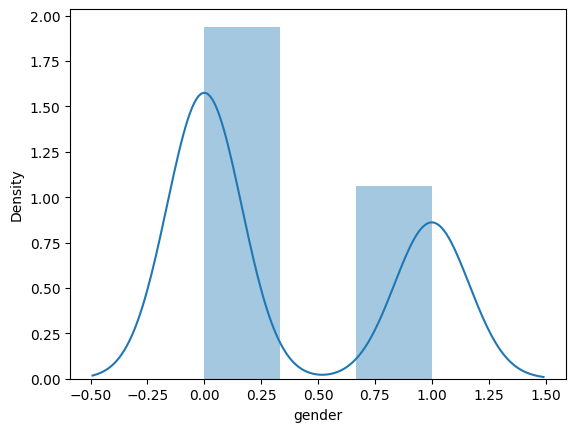

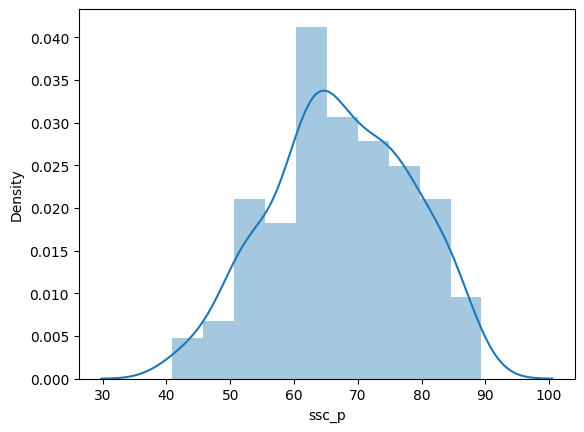

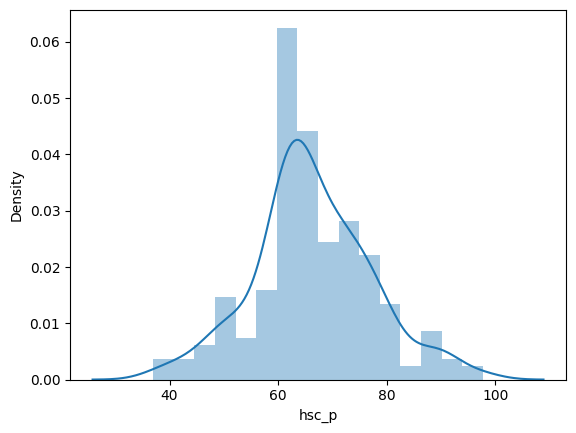

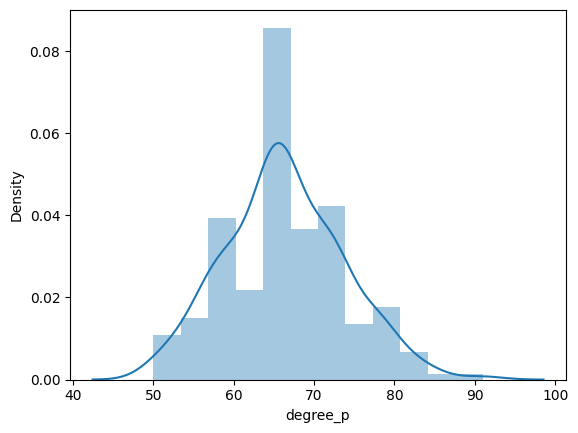

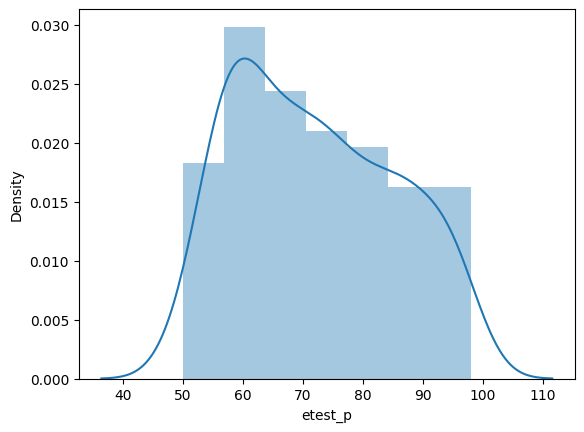

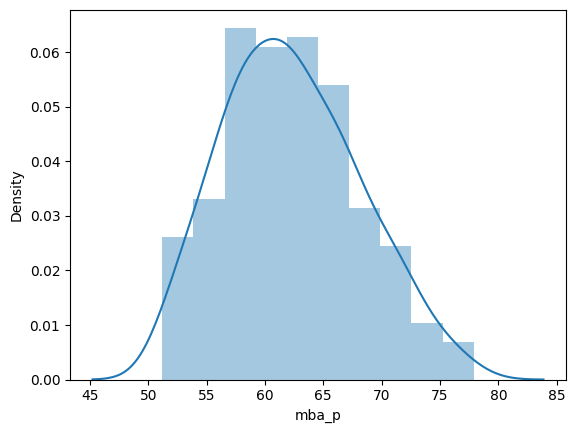

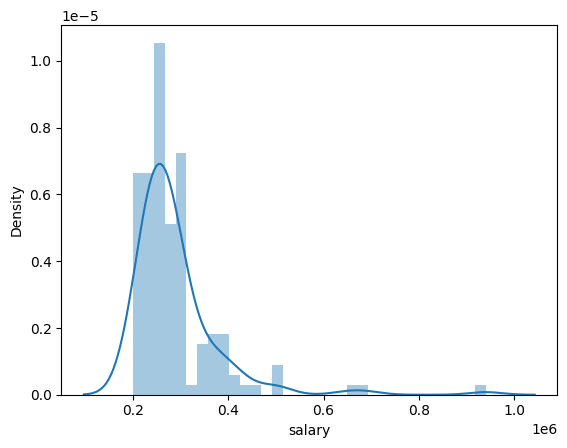

In [10]:
for colum in df.columns:
  if df[colum].dtype != 'object':
    sns.distplot(df[colum])
    plt.show()

We find than most of the columns present a Bell shape distribution, excepting the salary column which is righ skewed. Now we are going to take a look to the distributions in the categorical variables.

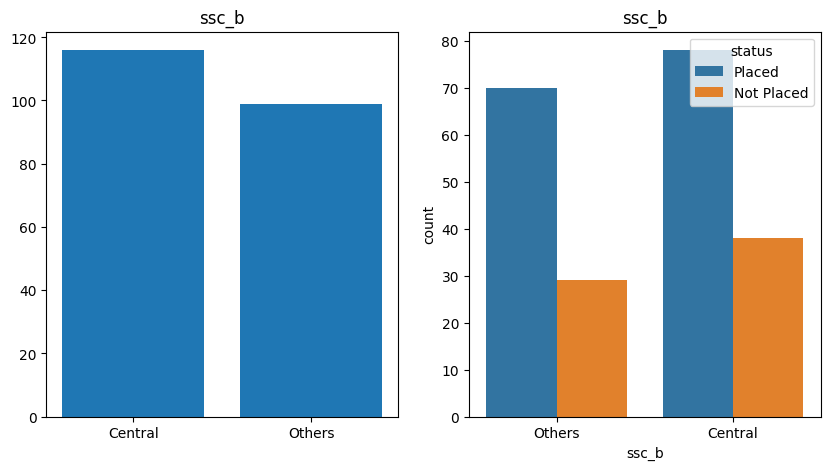

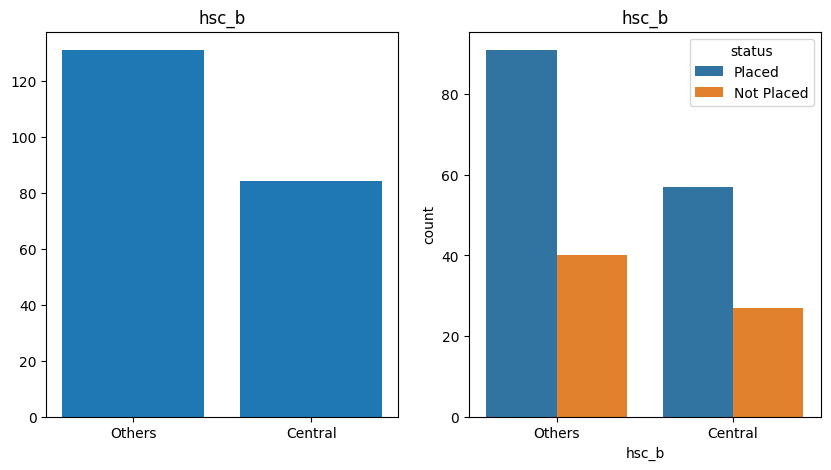

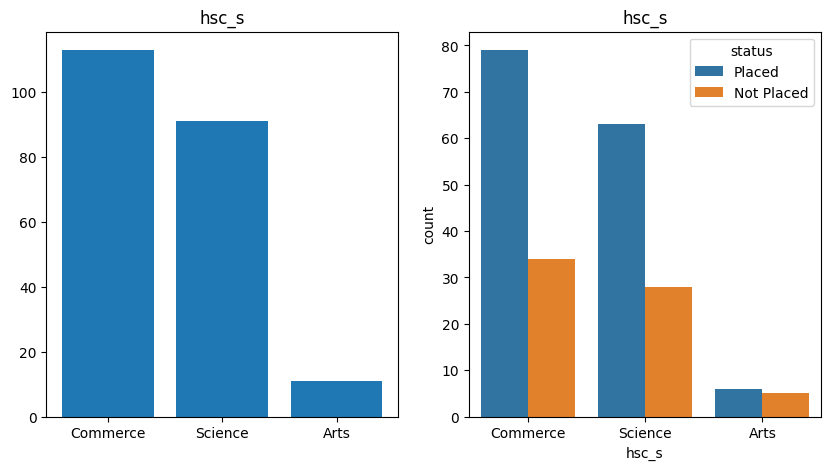

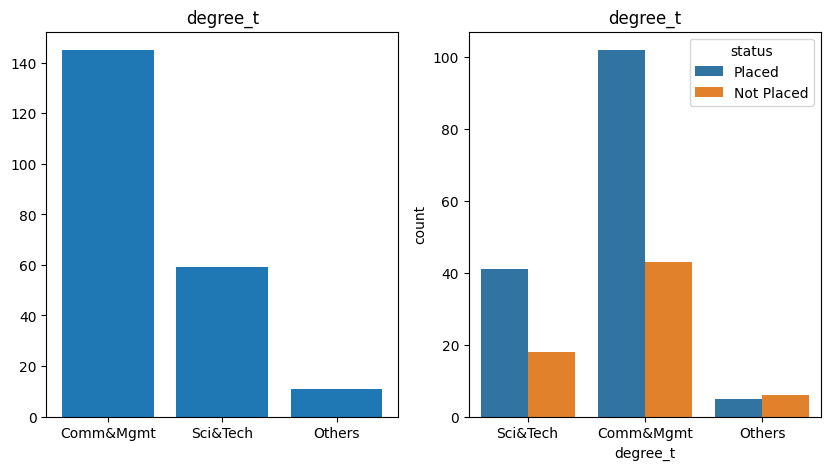

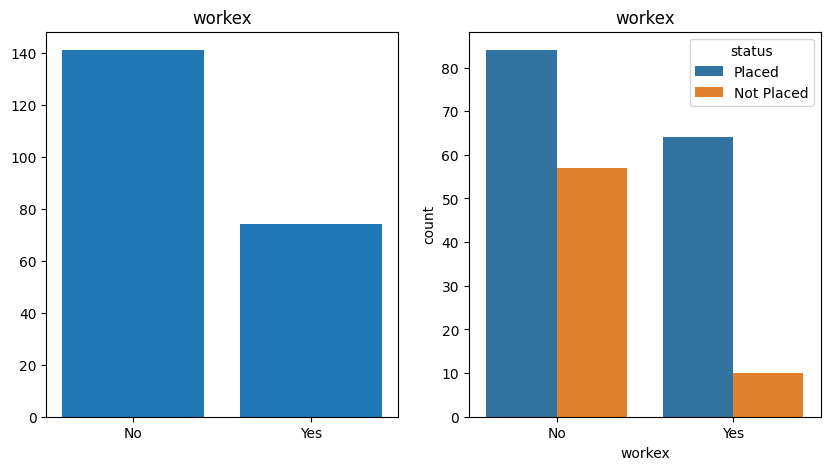

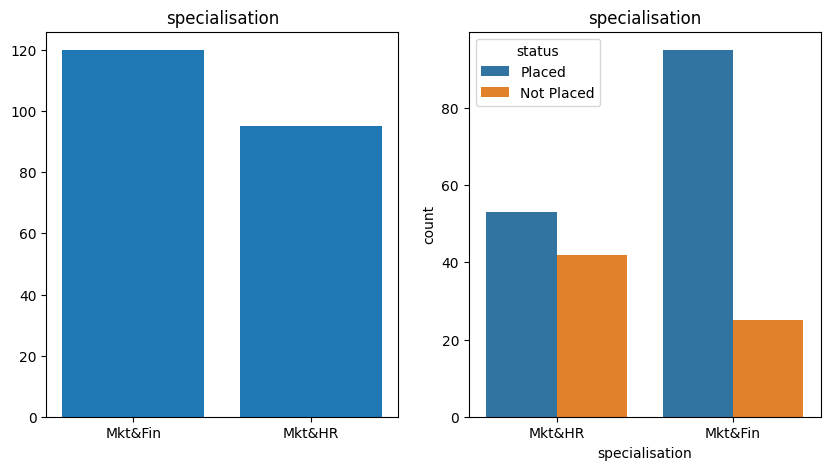

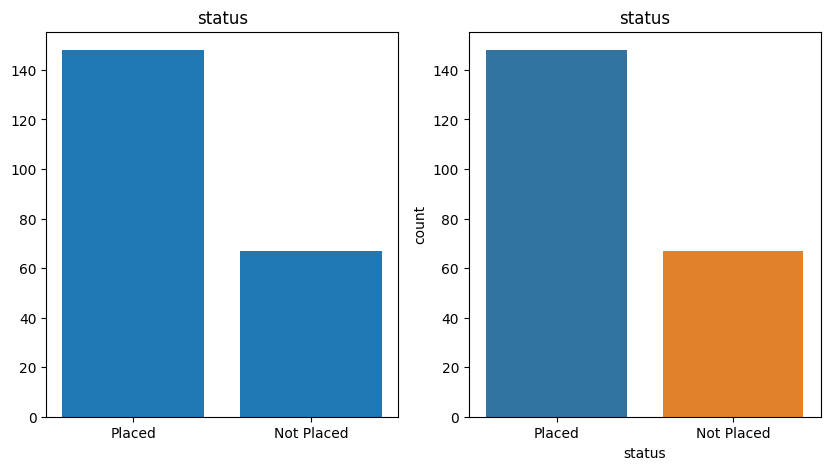

In [11]:
for colum in df.columns:
  if df[colum].dtype == 'object':
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.bar(df[colum].value_counts().index, df[colum].value_counts(), label='status' )
    plt.title(colum)
    plt.subplot(1,2,2)
    sns.countplot(x= colum, hue='status', data=df)
    plt.title(colum)
    plt.show()

Looking at the categorical variables we can see a clear pattern in which for every variable the relationship between placed and not placed is 2:1. However, thare are some excemptions:
- In the specialisation column the relationship between placed and nor placed is almost the same with the Mkt&HR specialisation, and in the Mkt&Fin the relationsip is aroun 4:1 between the placed and not placed
- We can see that people with other degrees have more people not placed than placed, which is uncomon in the dataset. The closest behaviour occurs in the Arts hsc_s where there is an eequal proportion between the placed and not placed.

Verifying the balance in the data, we find that the dataset is highly imbalanced, with more values of Placed than Not Placed

In [12]:
df['status'].value_counts()

,count
status,
Placed,148
Not Placed,67


## Feature encoding

First we are going to take a look of how many categories every categorical columns has:

In [13]:
for colum in df.columns:
  if df[colum].dtype == 'object':
    print(colum)
    print(df[colum].value_counts())

ssc_b
ssc_b
Central    116
Others      99
Name: count, dtype: int64
hsc_b
hsc_b
Others     131
Central     84
Name: count, dtype: int64
hsc_s
hsc_s
Commerce    113
Science      91
Arts         11
Name: count, dtype: int64
degree_t
degree_t
Comm&Mgmt    145
Sci&Tech      59
Others        11
Name: count, dtype: int64
workex
workex
No     141
Yes     74
Name: count, dtype: int64
specialisation
specialisation
Mkt&Fin    120
Mkt&HR      95
Name: count, dtype: int64
status
status
Placed        148
Not Placed     67
Name: count, dtype: int64


We see that 2 columns have 3 categories and the rest of the columns have 2 categories. Because of this, the ones with 2 categories are being encoder with label encoder and the ones with 3 categories are going to be encoded with one hot encoding. Giving the order in our target variable I am ecoding manually first the target variable to assign the correct labels

In [14]:
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for colum in df.columns:
  if df[colum].dtype == 'object':
    if df[colum].nunique() == 2:
      df[colum] = le.fit_transform(df[colum])


In [16]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,status
0,0,67.00,1,91.00,1,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,270000.0,1
1,0,79.33,0,78.33,1,Science,77.48,Sci&Tech,1,86.5,0,66.28,200000.0,1
2,0,65.00,0,68.00,0,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,250000.0,1
3,0,56.00,0,52.00,0,Science,52.00,Sci&Tech,0,66.0,1,59.43,NaN,0
4,0,85.80,0,73.60,0,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,425000.0,1


We see that the columns with 2 categories are now label encoded

In [17]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

columns = []

for column in df.columns:
  if df[column].dtype == 'object' and df[column].nunique() == 3:
    columns.append(column)

encoded_data = ohe.fit_transform(df[columns])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(columns))
df = pd.concat([df, encoded_df], axis=1)


In [18]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,status,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
0,0,67.00,1,91.00,1,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,270000.0,1,0.0,1.0,0.0,0.0,0.0,1.0
1,0,79.33,0,78.33,1,Science,77.48,Sci&Tech,1,86.5,0,66.28,200000.0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,0,65.00,0,68.00,0,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,250000.0,1,1.0,0.0,0.0,1.0,0.0,0.0
3,0,56.00,0,52.00,0,Science,52.00,Sci&Tech,0,66.0,1,59.43,NaN,0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,85.80,0,73.60,0,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,425000.0,1,0.0,1.0,0.0,1.0,0.0,0.0


Now we see that the rest of the columns are encoded with one hot encoding, getting 6 additional columns.

## Missing values and class imbalance dealing

Verifying the missing values, we find that there are only missing values in the salary column with 67 records.

In [19]:
df.isna().sum()

,0
gender,0
ssc_p,0
ssc_b,0
hsc_p,0
hsc_b,0
hsc_s,0
degree_p,0
degree_t,0
workex,0
etest_p,0


We can see that all the records with null values in the salary column are not placed. Giving the data imbalance we can not allow us to lose this records, so we are going to implement target imputation with the salaries related to the degree colum.

In [93]:
print('Not placed with Null salary: ', df[(df['salary'].isnull()) & (df['status'] == 0)].shape[0])
print('Placed with Null salary: ', df[(df['salary'].isnull()) & (df['status'] == 1)].shape[0])

Not placed with Null salary:  67
Placed with Null salary:  0


In order to adress class imbalance and deal with missing values we need to implement strategies that avoid **data leakeage**.

For this purpose I am taking the following approaches:
- Split the data into training and teting first to avoid data leakeage.
- Implement feature imputation using the degree column of the **training** dataset only. Then apply the same averages to impute the missing values in the text data.
- Implement SMOTE only in the training dataset, that wont have missing values.

In [21]:
X = df.drop('status', axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X_train.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
198,1,67.0,0,70.0,0,Commerce,65.0,Others,0,88.00,1,71.96,NaN,0.0,1.0,0.0,0.0,1.0,0.0
82,0,63.0,0,67.0,0,Commerce,74.0,Comm&Mgmt,0,82.00,0,60.44,NaN,0.0,1.0,0.0,1.0,0.0,0.0
65,0,54.0,1,47.0,1,Science,57.0,Comm&Mgmt,0,89.69,1,57.10,NaN,0.0,0.0,1.0,1.0,0.0,0.0
109,0,52.0,0,63.0,1,Science,65.0,Sci&Tech,1,86.00,1,56.09,NaN,0.0,0.0,1.0,0.0,0.0,1.0
182,0,52.0,1,65.0,1,Arts,57.0,Others,1,75.00,0,59.81,NaN,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
target_means = X_train.groupby('degree_t')['salary'].mean()
target_means

,salary
degree_t,
Comm&Mgmt,284041.666667
Others,300000.000000
Sci&Tech,305793.103448


Now we impute the missing values with the target values from the training dataset only

In [24]:
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Comm&Mgmt'), 'salary'] = target_means['Comm&Mgmt']
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Others'), 'salary'] = target_means['Others']
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Sci&Tech'), 'salary'] = target_means['Sci&Tech']


In [25]:
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Comm&Mgmt'), 'salary'] = target_means['Comm&Mgmt']
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Others'), 'salary'] = target_means['Others']
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Sci&Tech'), 'salary'] = target_means['Sci&Tech']


In [26]:
print('Missing values in X_train: ', X_train.isna().sum().sum())
print('Missing values in X_test: ', X_test.isna().sum().sum())

Missing values in X_train:  0
Missing values in X_test:  0


In [27]:
X_train.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
198,1,67.0,0,70.0,0,Commerce,65.0,Others,0,88.00,1,71.96,300000.000000,0.0,1.0,0.0,0.0,1.0,0.0
82,0,63.0,0,67.0,0,Commerce,74.0,Comm&Mgmt,0,82.00,0,60.44,284041.666667,0.0,1.0,0.0,1.0,0.0,0.0
65,0,54.0,1,47.0,1,Science,57.0,Comm&Mgmt,0,89.69,1,57.10,284041.666667,0.0,0.0,1.0,1.0,0.0,0.0
109,0,52.0,0,63.0,1,Science,65.0,Sci&Tech,1,86.00,1,56.09,305793.103448,0.0,0.0,1.0,0.0,0.0,1.0
182,0,52.0,1,65.0,1,Arts,57.0,Others,1,75.00,0,59.81,300000.000000,1.0,0.0,0.0,0.0,1.0,0.0


In [28]:
X_train.drop(columns=columns, inplace=True)
X_test.drop(columns=columns, inplace=True)

Now that we deal with the missing values avoiding data leakeage we can apply SMOTE to balance the training datasets

In [29]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

The last step to have our data ready to be modeled is to scale the values

In [30]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_resampled)
X_test_sc = sc.transform(X_test)

In [31]:
y_train_resampled.value_counts()

,count
status,
0,104
1,104


## Modeling

### Model 1: Logistic Regression

First we are going to modeling with a logistic regression model using gridsearchCV to evaluate different hyperparameters and perform crossvalidation

In [32]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 1, 100, False]}

lr = LogisticRegression(random_state=42)
gs_lr = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
gs_lr.fit(X_train_sc, y_train_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 1, 100, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1')

In [33]:
lr_model = gs_lr.best_estimator_
y_pred_lr = lr_model.predict(X_test_sc)

In [34]:
print(gs_lr.best_params_)
print(gs_lr.best_score_)
print(gs_lr.best_estimator_)

{'C': 1, 'penalty': 'l2'}
0.8803571781235451
LogisticRegression(C=1, random_state=42)


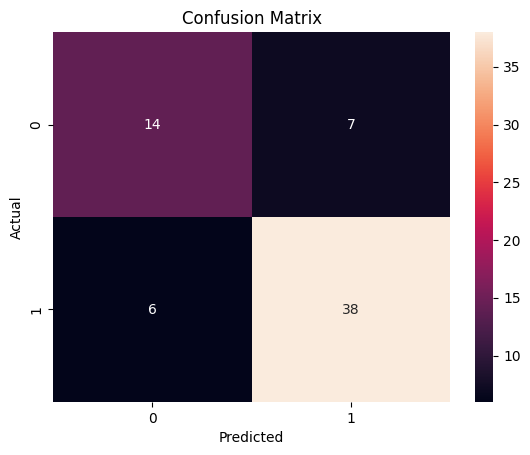

In [35]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
report = classification_report(y_test, y_pred_lr)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        21
           1       0.84      0.86      0.85        44

    accuracy                           0.80        65
   macro avg       0.77      0.77      0.77        65
weighted avg       0.80      0.80      0.80        65



In [37]:
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

In [79]:
print('Training metrics')
print('Precision: ', precision_score(y_train_resampled, lr_model.predict(X_train_sc)))
print('Recall: ', recall_score(y_train_resampled, lr_model.predict(X_train_sc)))
print('F1 Score: ', f1_score(y_train_resampled, lr_model.predict(X_train_sc)))
print('Accuracy: ', accuracy_score(y_train_resampled, lr_model.predict(X_train_sc)))
print('_'*50)
print('Testing metrics')
print('Precision: ', lr_precision)
print('Recall: ', lr_recall)
print('F1 Score: ', lr_f1)
print('Accuracy: ', lr_accuracy)

Training metrics
Precision:  0.9333333333333333
Recall:  0.9423076923076923
F1 Score:  0.937799043062201
Accuracy:  0.9375
__________________________________________________
Testing metrics
Precision:  0.8444444444444444
Recall:  0.8636363636363636
F1 Score:  0.8539325842696629
Accuracy:  0.8


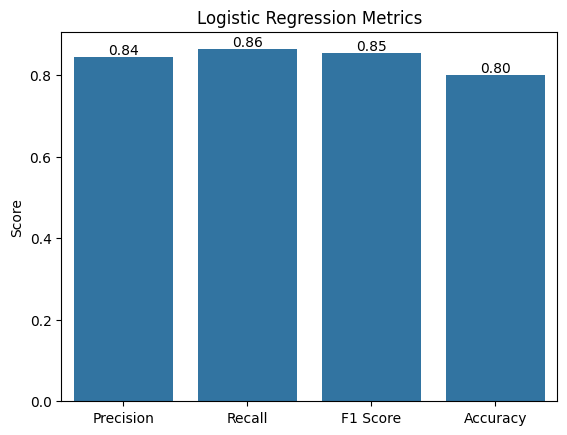

In [39]:
ax = sns.barplot(x=['Precision', 'Recall', 'F1 Score', 'Accuracy'], y=[lr_precision, lr_recall, lr_f1, lr_accuracy])
plt.ylabel('Score')
plt.title('Logistic Regression Metrics')

# Iterate through the bars and add text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

### Model 2: Support Vector Machines

Now we are going to evaluate the model with Support Vector Classifier

In [40]:
svc_param_grid = {'C': [0.01, 0.1, 1, 10, 20],
                  'kernel': ['linear', 'poly'],
                  'degree' : [2, 3]}

svc = SVC(random_state=42)
gs_svc = GridSearchCV(svc, svc_param_grid, cv=5, scoring='f1')
gs_svc.fit(X_train_sc, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 20], 'degree': [2, 3],
                         'kernel': ['linear', 'poly']},
             scoring='f1')

In [41]:
svc_model = gs_svc.best_estimator_
y_pred_svc = svc_model.predict(X_test_sc)

In [42]:
print(gs_svc.best_params_)
print(gs_svc.best_score_)
print(gs_svc.best_estimator_)

SVC(C=10, degree=2, kernel='linear', random_state=42)

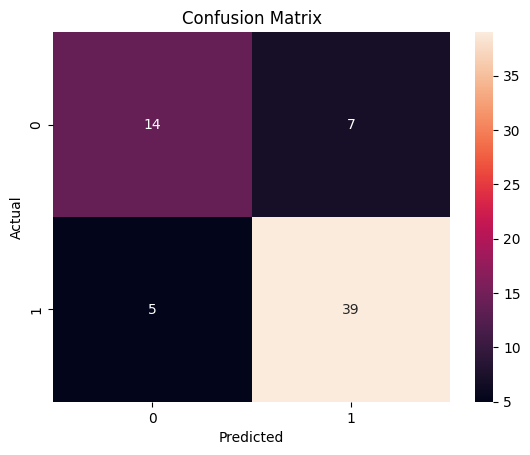

In [43]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70        21
           1       0.85      0.89      0.87        44

    accuracy                           0.82        65
   macro avg       0.79      0.78      0.78        65
weighted avg       0.81      0.82      0.81        65



In [45]:
svc_precision = precision_score(y_test, y_pred_svc)
svc_recall = recall_score(y_test, y_pred_svc)
svc_f1 = f1_score(y_test, y_pred_svc)
svc_accuracy = accuracy_score(y_test, y_pred_svc)

In [78]:
print('Training metrics')
print('Precision: ', precision_score(y_train_resampled, svc_model.predict(X_train_sc)))
print('Recall: ', recall_score(y_train_resampled, svc_model.predict(X_train_sc)))
print('F1 Score: ', f1_score(y_train_resampled, svc_model.predict(X_train_sc)))
print('Accuracy: ', accuracy_score(y_train_resampled, svc_model.predict(X_train_sc)))
print('_'*50)
print('Testing metrics')
print('Precision: ', svc_precision)
print('Recall: ', svc_recall)
print('F1 Score: ', svc_f1)
print('Accuracy: ', svc_accuracy)

Training metrics
Precision:  0.9514563106796117
Recall:  0.9423076923076923
F1 Score:  0.9468599033816425
Accuracy:  0.9471153846153846
__________________________________________________
Testing metrics
Precision:  0.8478260869565217
Recall:  0.8863636363636364
F1 Score:  0.8666666666666667
Accuracy:  0.8153846153846154


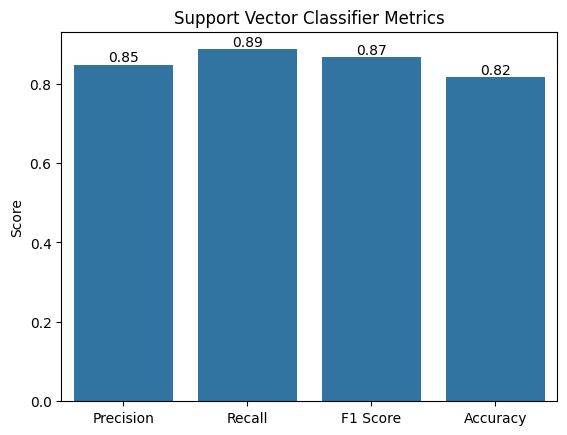

In [47]:
ax = sns.barplot(x=['Precision', 'Recall', 'F1 Score', 'Accuracy'], y=[svc_precision, svc_recall, svc_f1, svc_accuracy])
plt.ylabel('Score')
plt.title('Support Vector Classifier Metrics')

# Iterate through the bars and add text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

### Model 3: Random forest

Now we are going to evaluate the model with Random Forest

In [50]:
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

rf_gs= GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_gs.fit(X_train_sc, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

In [51]:
rf_model = rf_gs.best_estimator_
y_pred_rf = rf_model.predict(X_test_sc)

In [52]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)
print(rf_gs.best_estimator_)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
0.9584337233376667
RandomForestClassifier(n_estimators=500, random_state=42)


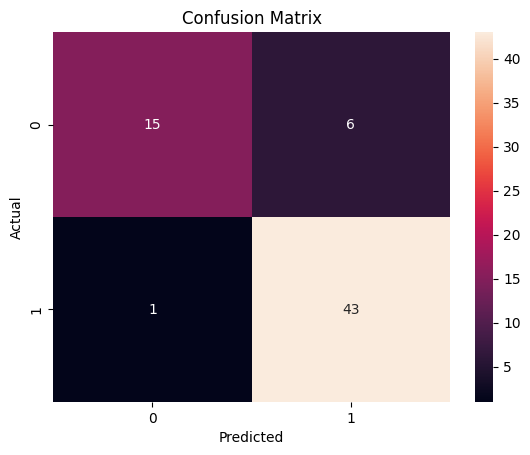

In [53]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81        21
           1       0.88      0.98      0.92        44

    accuracy                           0.89        65
   macro avg       0.91      0.85      0.87        65
weighted avg       0.90      0.89      0.89        65



In [55]:
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

In [77]:
print('Training metrics')
print('Precision: ', precision_score(y_train_resampled, rf_model.predict(X_train_sc)))
print('Recall: ', recall_score(y_train_resampled, rf_model.predict(X_train_sc)))
print('F1 Score: ', f1_score(y_train_resampled, rf_model.predict(X_train_sc)))
print('Accuracy: ', accuracy_score(y_train_resampled, rf_model.predict(X_train_sc)))
print('_'*50)
print('Testing metrics')
print('Precision: ', rf_precision)
print('Recall: ', rf_recall)
print('F1 Score: ', rf_f1)
print('Accuracy: ', rf_accuracy)

Training metrics
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Accuracy:  1.0
__________________________________________________
Testing metrics
Precision:  0.8775510204081632
Recall:  0.9772727272727273
F1 Score:  0.9247311827956989
Accuracy:  0.8923076923076924


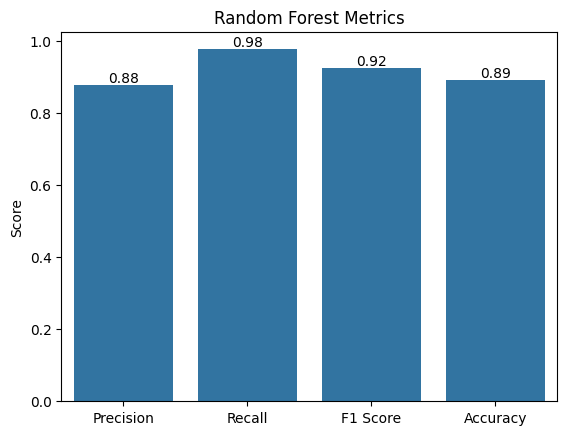

In [94]:
ax = sns.barplot(x=['Precision', 'Recall', 'F1 Score', 'Accuracy'], y=[rf_precision, rf_recall, rf_f1, rf_accuracy])
plt.ylabel('Score')
plt.title('Random Forest Metrics')

# Iterate through the bars and add text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

### Model 4: XGBoost

Now I am going to implement XGBoost giving its popularity, being considered as a model with great performance.

In [59]:
xgb_param_grid = {
    'n_estimators': [100, 200, 500],  # Default is 100
    'learning_rate': [0.3, 0.1, 0.01],  # Default is 0.3
    'max_depth': [3, 6, 7],  # Default is 6
}

xgb_gs = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='f1')
xgb_gs.fit(X_train_sc, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.3, 0.1, 0.01],
                         'max_depth': [3, 6, 7],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

In [60]:
xgb_model = xgb_gs.best_estimator_
y_pred_xgb = xgb_model.predict(X_test_sc)

In [61]:
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)
print(xgb_gs.best_estimator_)

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
0.9624916943521594
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


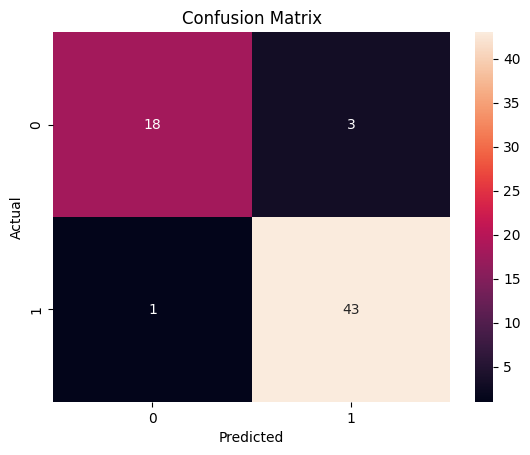

In [62]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [63]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.93      0.98      0.96        44

    accuracy                           0.94        65
   macro avg       0.94      0.92      0.93        65
weighted avg       0.94      0.94      0.94        65



In [64]:
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

In [76]:
print('Training metrics')
print('Precision: ', precision_score(y_train_resampled, xgb_model.predict(X_train_sc)))
print('Recall: ', recall_score(y_train_resampled, xgb_model.predict(X_train_sc)))
print('F1 Score: ', f1_score(y_train_resampled, xgb_model.predict(X_train_sc)))
print('Accuracy: ', accuracy_score(y_train_resampled, xgb_model.predict(X_train_sc)))
print('_'*50)
print('Testing metrics')
print('Precision: ', xgb_precision)
print('Recall: ', xgb_recall)
print('F1 Score: ', xgb_f1)
print('Accuracy: ', xgb_accuracy)

Training metrics
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Accuracy:  1.0
__________________________________________________
Testing metrics
Precision:  0.9347826086956522
Recall:  0.9772727272727273
F1 Score:  0.9555555555555556
Accuracy:  0.9384615384615385


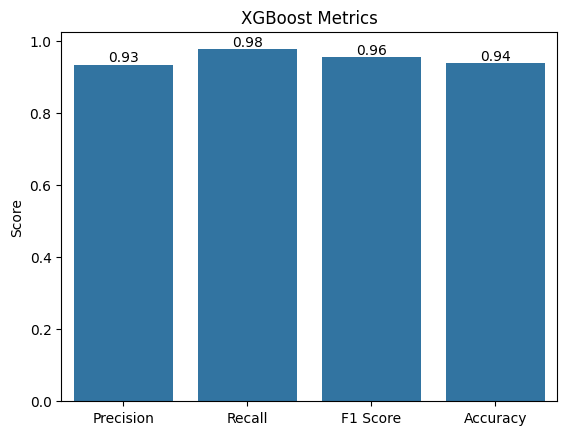

In [95]:
ax = sns.barplot(x=['Precision', 'Recall', 'F1 Score', 'Accuracy'], y=[xgb_precision, xgb_recall, xgb_f1, xgb_accuracy])
plt.ylabel('Score')
plt.title('XGBoost Metrics')

# Iterate through the bars and add text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

## Voting classifier

With all the evaluated models I define a voting classifier, choosing the best parameters in each one

In [81]:
lr = LogisticRegression(C=1, penalty='l2', random_state=42)
svc = SVC(C=10, degree=2, kernel='linear', random_state=42)
rf = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=500, random_state=42)
xgb = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=500, random_state=42)

vc= VotingClassifier(estimators=[('lr', lr), ('svc', svc), ('rf', rf), ('xgb', xgb)], voting='hard')
vc.fit(X_train_sc, y_train_resampled)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=42)),
                             ('svc',
                              SVC(C=10, degree=2, kernel='linear',
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_roun...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))])

In [83]:
y_pred_vc = vc.predict(X_test_sc)

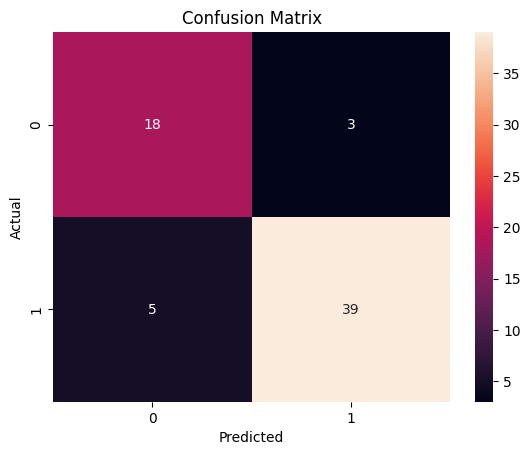

In [84]:
cm_vc = confusion_matrix(y_test, y_pred_vc)
sns.heatmap(cm_vc, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [85]:
print(classification_report(y_test, y_pred_vc))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.93      0.89      0.91        44

    accuracy                           0.88        65
   macro avg       0.86      0.87      0.86        65
weighted avg       0.88      0.88      0.88        65



In [87]:
vc_precision = precision_score(y_test, y_pred_vc)
vc_recall = recall_score(y_test, y_pred_vc)
vc_f1 = f1_score(y_test, y_pred_vc)
vc_accuracy = accuracy_score(y_test, y_pred_vc)

In [89]:
print('Training metrics')
print('Precision: ', precision_score(y_train_resampled, vc.predict(X_train_sc)))
print('Recall: ', recall_score(y_train_resampled, vc.predict(X_train_sc)))
print('F1 Score: ', f1_score(y_train_resampled, vc.predict(X_train_sc)))
print('Accuracy: ', accuracy_score(y_train_resampled, vc.predict(X_train_sc)))
print('_'*50)
print('Testing metrics')
print('Precision: ', vc_precision)
print('Recall: ', vc_recall)
print('F1 Score: ', vc_f1)
print('Accuracy: ', vc_accuracy)

Training metrics
Precision:  1.0
Recall:  0.9519230769230769
F1 Score:  0.9753694581280788
Accuracy:  0.9759615384615384
__________________________________________________
Testing metrics
Precision:  0.9285714285714286
Recall:  0.8863636363636364
F1 Score:  0.9069767441860465
Accuracy:  0.8769230769230769


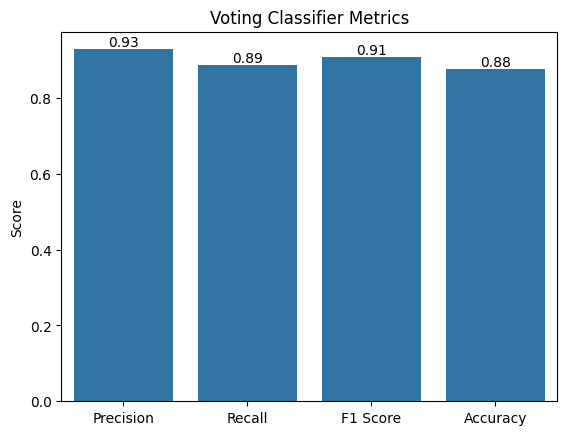

In [96]:
ax = sns.barplot(x=['Precision', 'Recall', 'F1 Score', 'Accuracy'], y=[vc_precision, vc_recall, vc_f1, vc_accuracy])
plt.ylabel('Score')
plt.title('Voting Classifier Metrics')

# Iterate through the bars and add text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

## F1 comparison between models

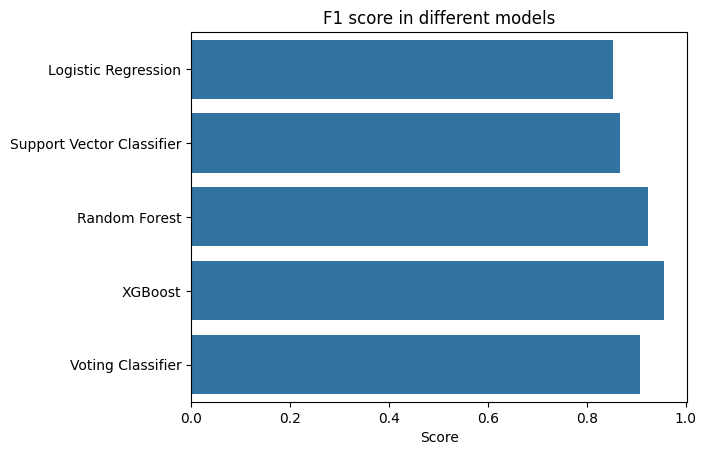

In [92]:
ax = sns.barplot(y=['Logistic Regression', 'Support Vector Classifier', 'Random Forest', 'XGBoost', 'Voting Classifier'],
                 x=[lr_f1, svc_f1, rf_f1, xgb_f1, vc_f1],
                 orient='h')
plt.xlabel('Score')
plt.title('F1 score in different models')

plt.show()